# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns

from PIL import Image as im

import math
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import sem
import scipy.signal as sgnl
from scipy import interpolate

import tkinter as tk
import tkinter.filedialog
import tkinter.messagebox
import os
import glob
import time

#from ast import literal_eval


import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 8
axis_font_size = 8

from matplotlib.ticker import MaxNLocator

from numpy.random import default_rng

# Functions

In [20]:
## first three functions used for nuclei simulations

def set_size(w,h, ax=None):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)   
    
def too_close(xy, xytemp, diam):
    too_close = False
    for i in range(int(len(xy)/2)):
        distance = np.sqrt( (xy[2*i]- xytemp[0])**2 + (xy[2*i+1]- xytemp[1])**2)
        if (distance > diam):
            too_close_temp = False
        else :
            too_close_temp = True
        too_close = too_close | too_close_temp
    return too_close

## Functions dedicated to sarcomere simulations
def new_image(rows, cols):
    """ Creates a new image based on input sizes"""
    return np.array([[0]*cols]*rows)


def add_noise_to_image(array, amplitude):
    """ Add Poisson noise to input image at given amplitude"""
    rows, cols = array.shape
    new_array = array.copy()
    for i in range(rows):
        for j in range(cols):
            new_array[i,j] = array[i,j] + np.random.poisson(lam=amplitude)
    return new_array

def add_sarcomeres(array, sarc_length, sarc_amplitude = 255):
    """ Add sarcomere as single bands, each filling a column of an input array"""
    rows, cols = array.shape
    num_z_disk = int(cols/sarc_length)
    #first at half sarcomere size from left side
    positions = [int(sarc_length) + i*sarc_length for i in range(num_z_disk)]
    new_array = array.copy()
    for i in positions:
        for k in range(rows):
            new_array[k,i] = array[k,i] + sarc_amplitude
    return new_array

def add_random_sarcomeres(array, sarc_length, sarc_amplitude = 255, sd_norm = 1):
    """ Add sarcomere as single bands, positionned with bilinear interpolation when not fitting perfectly """
    """ the column number"""
    
    rows, cols = array.shape
    num_z_disk = int(cols/sarc_length)
    #first at half sarcomere size from left side
    positions = np.zeros(num_z_disk)
    positions[0] = sarc_length
    positions[num_z_disk-1] = (num_z_disk)*sarc_length
    for i in range(num_z_disk-2):
        positions[i+1] = (i + 2 + np.random.normal(0, sd_norm, 1)[0])*sarc_length 
    
    new_array = array.copy()
    for i in positions:
        q = int(i) 
        r = i%int(i) 
        for k in range(rows):
            new_array[k,q] = array[k,q] + (1-r)*sarc_amplitude
            if(q<cols):
                new_array[k,q+1] = array[k,q+1] + r*sarc_amplitude
    return new_array, positions

def add_sarcomeres_random_intensity(array, sarc_length, sarc_amplitude = 255, sd_norm = 0, sd_norm_sarc_ampl = 0.1):
    """ Add sarcomere as single bands, positionned with bilinear interpolation when not fitting perfectly """
    """ the column number. The amplitude of a single band is chosen randomly in a normal distribution. """
    
    rows, cols = array.shape
    num_z_disk = int(cols/sarc_length)
    #first at half sarcomere size from left side
    positions = np.zeros(num_z_disk)
    amplitudes = np.zeros(num_z_disk)
    positions[0] = sarc_length
    positions[num_z_disk-1] = (num_z_disk)*sarc_length
    for i in range(num_z_disk-2):
        positions[i+1] = (i + 2 + np.random.normal(0, sd_norm, 1)[0])*sarc_length
    
    new_array = array.copy()
    for i in range(num_z_disk):
        amplitudes[i] = (1 + np.random.normal(0, sd_norm_sarc_ampl, 1)[0])*sarc_amplitude
        q = int(positions[i]) 
        r = positions[i]%int(positions[i]) 
        for k in range(rows):
            new_array[k,q] = array[k,q] + (1-r)*amplitudes[i]
            if(q<cols):
                new_array[k,q+1] = array[k,q+1] + r*amplitudes[i]
    return new_array, amplitudes

def add_multiple_bands(array, sarc_length, sarc_amplitude, array_of_bands, sd_norm = 0):
    """ Add sarcomere as single bands, positionned with bilinear interpolation when not fitting perfectly """
    """ the column number """
    """ the array of bands is a list of bands centered on the z-disk, [-2,2] for instance  """
    
    rows, cols = array.shape
    num_z_disk = int(cols/sarc_length)
    #first at half sarcomere size from left side
    zdisk_positions = np.zeros(num_z_disk)
    zdisk_positions[0] = sarc_length
    zdisk_positions[num_z_disk-1] = (num_z_disk)*sarc_length
    for i in range(num_z_disk-2):
        zdisk_positions[i+1] = (i + 2 + np.random.normal(0, sd_norm, 1)[0])*sarc_length
        
    band_positions = np.zeros(num_z_disk*len(array_of_bands))
    for i in range(num_z_disk):
        for j in range(len(array_of_bands)):
            band_positions[i*len(array_of_bands) + j] = zdisk_positions[i] + array_of_bands[j]
    
    new_array = array.copy()
    for i in band_positions:
        q = int(i) 
        r = i%int(i) 
        for k in range(rows):
            new_array[k,q] = array[k,q] + (1-r)*sarc_amplitude
            if(q<cols):
                new_array[k,q+1] = array[k,q+1] + r*sarc_amplitude
    return new_array, band_positions
    
def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)    
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)               
    #print size, sizey    
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-2*(x**2/float(size**2)+y**2/float(sizey**2)))
    return g / g.sum()

def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of waist of
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
        According to https://en.wikipedia.org/wiki/Airy_disk, the Airy disk radius
        is 1.22 lambda N and the corresponding waist is wo = 0.84 lambda N, where N is the f-number.
        Note that in wikipedia the gaussian function takes the form I = Io * exp(-2 r² / wo²)
        The pixel size should be set to half the Airy radius, so 1 pix = 1.22 lambda N/2.
        Using wo = 0.84 lambda N, you find that wo expressed in pixels should then be
        wo = 2*0.84/1.22 = 1.377
        1 pix = 1.22 lambda/4 NA, at 550 is 129 nm
        If the image is oversampled by a factor fact, then wo = 1.377 * fact
    """
    g = gauss_kern(n, sizey=ny)
    improc = sgnl.convolve(im,g, mode='same')
    return(improc)   

def resize_bilinear_interp(array, resize = 2):
    rows, cols = array.shape
    x = np.array(range(rows))
    y = np.array(range(cols))
    z = array
    #f = interpolate.interp2d(y, x, z, kind='linear')
    f = interpolate.RegularGridInterpolator((x, y), z, method='linear')

    xnew = np.array(np.arange(int(rows/resize))*resize)
    ynew = np.array(np.arange(int(cols/resize))*resize)
    X, Y = np.meshgrid(xnew, ynew, indexing='ij')
    array_new = f((X,Y))
    
    return array_new

# Simulate sarcomeres

### One sarcomere length, varying SNR

(50, 1370)
(50, 1370)
(10, 274)


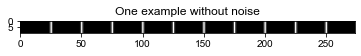

In [3]:
enlargement = 5
arr = new_image(10*enlargement, 274*enlargement)#rows, cols
arr = add_sarcomeres(arr, 25*enlargement, 50)#sarc_length, sarc_amplitude. 
print(arr.shape)
""" Here hypothesis is sarc length = 25 pixels*1.22*lambda/4NA = 30*550/(4*1.3) = 3.226 µm """
arr = blur_image(arr, 1.377*enlargement)
print(arr.shape)
arr = resize_bilinear_interp(arr, resize = enlargement)
""" Final image is 20 x 359 pixels """
print(arr.shape)

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()


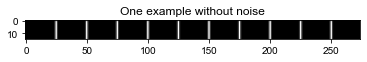

In [5]:
enlargement = 5
arr = new_image(15*enlargement, 274*enlargement)#rows, cols
arr = add_sarcomeres(arr, 25*enlargement, 50)#sarc_length, sarc_amplitude. 
""" Here hypothesis is sarc length = 25 pixels*1.22*lambda/4NA = 30*550/(4*1.3) = 3.226 µm """
arr = blur_image(arr, 1.377*enlargement)
arr = resize_bilinear_interp(arr, resize = enlargement)
""" Final image is 20 x 359 pixels """

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

amplitude = np.max(arr) - np.min(arr)

SNR_list = [0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0]

np.random.seed(42)

for SNR in SNR_list:
    noise_var = amplitude**2/(SNR**2)
    for i in range(1000):
        arr_with_noise = add_noise_to_image(arr, noise_var) #poisson noise, variance = lambda
        data = im.fromarray(arr_with_noise)
        
        # HOME
        # data.save(r'C:\Users\pierr\Desktop\Research\SaNJ\single_band_var_noise'+'\\SNR_'+str(SNR)+'_image_'+ str(i)+'.tif')
        
        # WORK
        data.save(r'C:\\Users\\mangeol\\Desktop\\SaNJ\\Analyses\\single_band_var_noise'+'\\SNR_'+str(SNR)+'_image_'+ str(i)+'.tif')

#### Image to show gradient of noise

(1250, 1370)
(1250, 1370)
(250, 274)


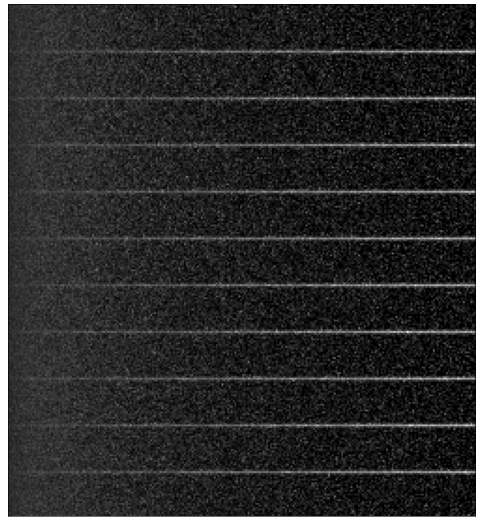

In [49]:
enlargement = 5
arr = new_image(250*enlargement, 274*enlargement)#rows, cols
arr = add_sarcomeres(arr, 25*enlargement, 50)#sarc_length, sarc_amplitude. 
print(arr.shape)
""" Here hypothesis is sarc length = 25 pixels*1.22*lambda/4NA = 30*550/(4*1.3) = 3.226 µm """
arr = blur_image(arr, 1.377*enlargement)
print(arr.shape)
arr = resize_bilinear_interp(arr, resize = enlargement)
""" Final image is 20 x 359 pixels """
print(arr.shape)

######################################################
### add noise for each column from 1 to 8
######################################################
amplitude = np.max(arr) - np.min(arr)

rows, cols = arr.shape
new_array = arr.copy()
for i in range(rows):
    #for j in range(cols):
    SNR = 1+((i)/rows)*7
    var = amplitude**2/(SNR**2)
    new_array[i,:] = arr[i,:] + np.random.poisson(lam=var, size = cols)
        
for i in range(rows):
    new_array[i,:]  = new_array[i,:]*(i+10)#/sum(new_array[i,:])*255 
dpi = 51.2
width = 10
height = 10
fig = plt.figure(figsize=(width, height), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], aspect=1)
plt.gray()
plt.imshow(new_array.T)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(r"C:\Users\mangeol\Desktop\SaNJ\manuscript\Figure 2\data\growing_SNR_1_to_8.tiff")
plt.show()

In [26]:
((rows-i)/rows)*8

0.032

### Varying sarcomere length, varying SNR

(75, 1370)
(75, 1370)


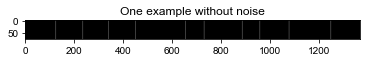

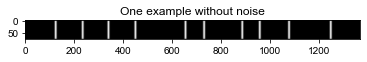

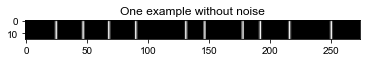

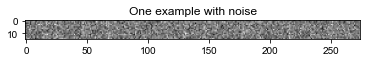

In [3]:
enlargement = 5
sd_sarc = 0.25
arr = new_image(15*enlargement, 274*enlargement)#rows, cols
print(arr.shape)
arr, positions = add_random_sarcomeres(arr, 25*enlargement, 250, sd_sarc)#sarc_length, sarc_amplitude. sd_sarc is the normalized standard deviation on the sarc_length;
# the standard deviation on the sarc_length is therefore sd_sarc * sarc_length. 
print(arr.shape)
plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

""" Here hypothesis is average sarc length = 25 pixels*1.22*lambda/4NA = 25*550*1.22/(4*1.3) = 3.225962 µm """
arr = blur_image(arr, 1.377*enlargement)

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

arr = resize_bilinear_interp(arr, resize = enlargement)
""" Final image is 20 x 400 pixels """

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

amplitude = np.max(arr) - np.min(arr)
SNR = 1
noise_var = amplitude**2/(SNR**2)
arr_with_noise = add_noise_to_image(arr, noise_var) 

plt.gray()
plt.imshow(arr_with_noise)
plt.title("One example with noise")
plt.show()

In [3]:

""" Here hypothesis is average sarc length = 25 pixels*1.22*lambda/4NA = 25*550*1.22/(4*1.3) = 3.89 µm """

#SNR_list = [0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0]
SNR_list = [0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0]

#sd_sarc_length = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
sd_sarc_length = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10]

enlargement = 5

np.random.seed(42)
arr = new_image(15*enlargement, 274*enlargement)#rows, cols
for sd_sarc in sd_sarc_length:
    for SNR in SNR_list:
        
        for i in range(1000):
            arr_with_sarc, positions = add_random_sarcomeres(arr, 25*enlargement, 50, sd_sarc)#sarc_length, sarc_amplitude.
            arr_with_sarc = blur_image(arr_with_sarc, 1.377*enlargement)
            arr_with_sarc = resize_bilinear_interp(arr_with_sarc, resize = enlargement)
            amplitude = np.max(arr_with_sarc) - np.min(arr_with_sarc)
            noise_var = amplitude**2/(SNR**2)
            arr_with_noise = add_noise_to_image(arr_with_sarc, noise_var) #poisson noise, variance = lambda
            data = im.fromarray(arr_with_noise)
            # HOME
            #data.save(r'C:\Users\pierr\Desktop\Research\SaNJ\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str(sd_sarc)+'_image_'+ str(i)+'.tif')
            #positions.tofile(r'C:\Users\pierr\Desktop\Research\SaNJ\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str(sd_sarc)+'_image_'+ str(i)+'.csv', sep = ',')
            
            # WORK
            data.save(r'C:\Users\mangeol\Desktop\SaNJ\Analyses\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str('%.2f'%sd_sarc)+'_image_'+ str(i)+'.tif')
            positions.tofile(r'C:\Users\mangeol\Desktop\SaNJ\Analyses\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str('%.2f'%sd_sarc)+'_image_'+ str(i)+'.csv', sep = ',')
 

(100, 1750)
[ 150.  300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650.]
(100, 1750)


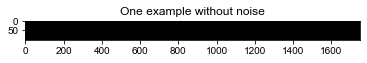

In [23]:

enlargement = 5
sarc_length = 30*enlargement
sd_norm = 0
sd_sarc = 0
arr = new_image(20*enlargement, 350*enlargement)#rows, cols
print(arr.shape)
rows, cols = arr.shape
num_z_disk = int(cols/sarc_length)
#first at half sarcomere size from left side
positions = np.zeros(num_z_disk)
positions[0] = sarc_length
positions[num_z_disk-1] = (num_z_disk)*sarc_length
for i in range(num_z_disk-2):
    positions[i+1] = (i + 2 + np.random.normal(0, sd_norm, 1))*sarc_length 

print(positions)
new_array = arr.copy()
for i in positions:
    q = int(i) 
    r = i%int(i) 
    for k in range(rows):
        new_array[k,q] = arr[k,q] + (1-r)*255
        new_array[k,q+1] = arr[k,q+1] + r*255
        
print(new_array.shape)
plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

### One sarcomere length varying band intensity, varying SNR

(75, 1370)
(75, 1370)


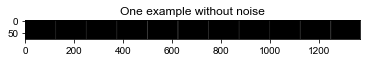

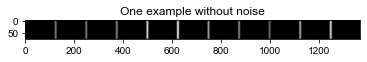

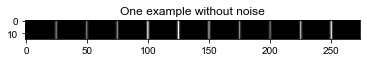

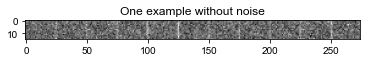

In [13]:
enlargement = 5
sd_sarc = 0
sd_norm_sarc_ampl = 0.25
arr = new_image(15*enlargement, 274*enlargement)#rows, cols
print(arr.shape)

arr, amplitudes = add_sarcomeres_random_intensity(arr, 25*enlargement, 250, sd_sarc, sd_norm_sarc_ampl)#sarc_length, sarc_amplitude. sd_sarc is the normalized standard deviation on the sarc_length;
# the standard deviation on the sarc_length is therefore sd_sarc * sarc_length. 
print(arr.shape)
plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

""" Here hypothesis is average sarc length = 30 pixels*1.22*lambda/4NA = 30*550*1.22/(4*1.3) = 3.89 µm """
arr = blur_image(arr, 1.377*enlargement)

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

arr = resize_bilinear_interp(arr, resize = enlargement)
""" Final image is 20 x 400 pixels """

plt.gray()
plt.imshow(arr)
plt.title("One example without noise")
plt.show()

amplitude = np.max(arr) - np.min(arr)
SNR = 3
noise_var = amplitude**2/(SNR**2)
arr_with_noise = add_noise_to_image(arr, noise_var) 

plt.gray()
plt.imshow(arr_with_noise)
plt.title("One example without noise")
plt.show()

In [14]:
""" Here hypothesis is average sarc length = 30 pixels*1.22*lambda/4NA = 30*550*1.22/(4*1.3) = 3.89 µm """

SNR_list = [0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0]
sd_norm_sarc_ampl_list = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
sd_sarc_length = 0
enlargement = 5

np.random.seed(42)
arr = new_image(15*enlargement, 274*enlargement)#rows, cols
for sd_norm_sarc_ampl in sd_norm_sarc_ampl_list:
    for SNR in SNR_list:
        
        for i in range(100):
            arr_with_sarc, amplitudes = add_sarcomeres_random_intensity(arr, 25*enlargement, 50, sd_sarc_length, sd_norm_sarc_ampl)#sarc_length, sarc_amplitude.
            arr_with_sarc = blur_image(arr_with_sarc, 1.377*enlargement)
            arr_with_sarc = resize_bilinear_interp(arr_with_sarc, resize = enlargement)
            amplitude = np.max(arr_with_sarc) - np.min(arr_with_sarc)
            noise_var = amplitude**2/(SNR**2)
            arr_with_noise = add_noise_to_image(arr_with_sarc, noise_var) #poisson noise, variance = lambda
            data = im.fromarray(arr_with_noise)
            # HOME
            #data.save(r'C:\Users\pierr\Desktop\Research\SaNJ\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str(sd_sarc)+'_image_'+ str(i)+'.tif')
            #positions.tofile(r'C:\Users\pierr\Desktop\Research\SaNJ\single_band_var_noise_var_sarclength'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str(sd_sarc)+'_image_'+ str(i)+'.csv', sep = ',')
            
            # WORK
            data.save(r'C:\Users\mangeol\Desktop\SaNJ\Analyses\single_band_var_noise_var_sarc_intensity'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str('%.2f'%sd_norm_sarc_ampl)+'_image_'+ str(i)+'.tif')
            amplitudes.tofile(r'C:\Users\mangeol\Desktop\SaNJ\Analyses\single_band_var_noise_var_sarc_intensity'+'\\SNR_'+str(SNR)+'_sd_sarc_'+str('%.2f'%sd_norm_sarc_ampl)+'_image_'+ str(i)+'.csv', sep = ',')
 